In [1]:
from canonymous.canonicalization import (graph_from_file,
                                         partition_molecule_by_attribute,
                                         partition_molecule_recursively,
                                         assign_canonical_labels,
                                         canonicalize_molecule,
                                         serialize_molecule,
                                         permute_molecule)
from canonymous.visualization import print_molecule, draw_molecules
from pathlib import Path
import networkx as nx


def construct_filepath(name, testset="mol"):
    path = None
    if testset == "mol":
        path = Path(f"tests/molfiles/{name}/{name}.mol")
    elif testset == "cfi":
        path = Path(f"tests/cfi_rigid_benchmark_graphs/{name}.col")
    return path

# Canonicalization

## Introduction
A molecule can be represented as a graph with atoms as nodes and bonds as edges.
To identify the nodes they are labeled with integers.
When two chemists draw the same molecule, they'll probably label the atoms differently (by drawing the atoms in different orders for instance), as illustrated with the example of ethanol in `Figure 1`.

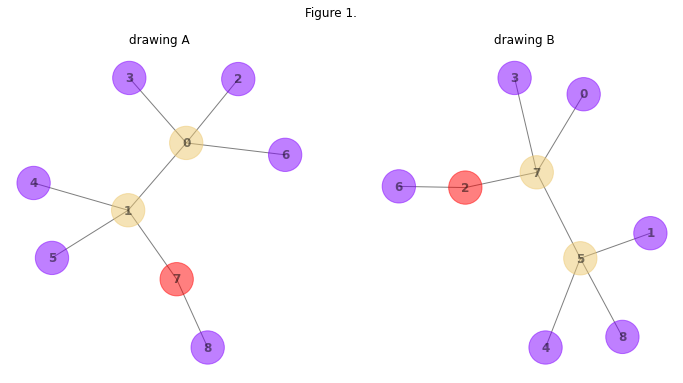

In [2]:
m = graph_from_file(construct_filepath("ethanol"))
m_permuted = permute_molecule(m)
draw_molecules([m, m_permuted], ["drawing A", "drawing B"], highlight="atomic_number", title="Figure 1.")

If both molecules were saved in a database, we'd end up with duplicate molecules,
since the chemical structures are equivalent and merely differ in the labels (automorphic).
How do we know that the chemists are submitting the same molecule to the database?
This problem can be solved with canonicalization, that is, by assigning unique (canonical) node labels such that any two molecules that are isomorphic receive the same labelling.
According to [Reed & Corneil (1977)](https://sci-hub.ru/https://doi.org/10.1002/jgt.3190010410), "[t]wo [molecules M]1 and [M]2 are isomorphic if there exists a one-to-one mapping of the [nodes] of [M]1 onto the [nodes] of [M]2 such that adjacency is preserved,
i.e. two [nodes] in [M]1 are adjacent if and only if the corresponding [nodes] of [M]2 are adjacent."
However, the process of finding a canonical labeling can be computationally expensive. 
TODO: Explain brute-force canonicalization / generating all permutations of node labels.
The computational costs of generating all `N!` permutations of the node labels can be reduced substantially by partitioning the nodes into subsets based on invariants.

## Molecule partitioning based on node-invariants
In the following, we use the term _invariant_ in the sense of _node-invariant_ (pertaining to a single node) as opposed to _graph-invariant_ (pertaining to the entire graph). Invariants are node-properties that are independent of the labeling. For instance, in `Figure 1`,
the red oxygen atom, irrespective of its label, will always have the atomic number 8, and will always be connected to one carbon and one hydrogen.
The nodes in a partition are equivalent w.r.t. to the invariants Note that this does not imply that nodes within the same partition are automorphic ([Ivanciuc, 2008](https://sci-hub.ru/10.1002/9783527618279.ch7a)). An automorphism group (aka orbit) is a set of nodes that have a structurally equivalent position in the graph, in other words, the atoms are symmetry-equivalent. For example, the three automorphism groups in `Figure 2` below are {0, 1, 2, 3}, {4, 5}, and {6, 7}. The nodes within those groups are structurally interchangeable (as soon as stereochemistry comes into play this might not be true anymore in many cases).


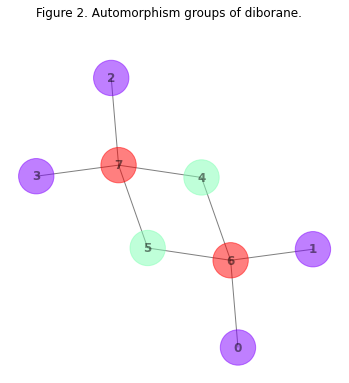

In [3]:
m = graph_from_file(construct_filepath("diborane"))
draw_molecules([canonicalize_molecule(m)], [""], highlight="partition", title="Figure 2. Automorphism groups of diborane.")


Equivalence w.r.t. the invariants is necessary but not sufficient for automorphism.
If each node resides in a partition of size 1, the molecule has been canonicalized, since each node can be uniquely identified by its partition. We therefore aim to partition the molecule such that each partition contains as few nodes as possible, and to achieve this, we need invariants with strong discriminatory power.

We use the following invariants to divide the nodes into initial partitions.
### Atomic number
The atomic number is a straightforward invariant that doesn't require additional computation.
However, in cases of pure substances such as sulfur, the atomic number has no discriminatory power: all nodes are allocated to the same partition.
In general, based on atomic number alone, we can obtain at most as many partitions as there are different elements in a chemical structure.
### Fundamental cycles
Fundamental cycles are a generalization of [chordless cycles](https://en.wikipedia.org/wiki/Induced_path), such that the chord can contain more than one edge.
For the detection of fundamental cycles, we implemented a variation of the algorithm that has been proposed by [Gashler & Martinez (2012)](https://sci-hub.ru/10.1080/09540091.2012.664122) in their Figure 6.
Note that what Gashler and Martinez refer to as _atomic cycle_, we call _fundamental cycle_.
In doing so, we hope to avoid ambiguity arising from the chemical connotation of the term _atomic_.
Importantly, fundamental cycles are not equivalent to chemical rings. While each fundamental cycle is a chemical ring, not every chemical ring is a fundamental cycle. 
In order to obtain an invariant from the fundamental cycles, we associate each node `a` with all fundamental cycles that contain `a`.

TODO: Show example.

Each fundamental cycle is identified with an integer label, which is not meant to imply that these labels are ordinal, one cycle does not have precedence over the other. The labels are merely meant to distinguish the fundamental cycles from each other. We could use city names but integer labels are more convenient. Strictly speaking, fundamental cycles are not invariants, since the cycle labels depend on the node labels. Fundamental cycles split automorphism groups. For example, the ring atoms in bicyclohexane (TODO: show) would be automorphic without the fundamental cycle invariant. TODO: What are the implications of this for correctness of canonicalization (make question more precise)?

### Invariant-code
Based on the atomic number and the fundamental cycles, we generate an invariant-code for each node: `<atomic number>-<comma-separated list of fundamental cycles>`.
Consider for example the invariant-code of the node with label 12 in `Table 1` below.

`6-2,1,0`

The leading 6 indicates that the node represents a carbon atom. Further, we can infer that it's part of two fundamental cycles: 2 and 1.
Note that all nodes carry a trailing 0 in their invariant-codes. The 0s are placeholders in case a node does not belong to a fundamental cycle.
As is evident from `Table 1` and `Figure 3` below, the invariant-code partitions the molecule into four subsets (partition 0 through 3).

Table 1. Fused_bicycle partitioned by invariant-code.
╒═════════╤══════════════════╤═════════════╤═════════════════════════════════════════════════╕
│   label │ invariant-code   │   partition │ neighbors (label, invariant-code, partition)    │
╞═════════╪══════════════════╪═════════════╪═════════════════════════════════════════════════╡
│       0 │ 1-0              │           0 │ (6, 6-1,0, 1)                                   │
├─────────┼──────────────────┼─────────────┼─────────────────────────────────────────────────┤
│       1 │ 1-0              │           0 │ (7, 6-1,0, 1)                                   │
├─────────┼──────────────────┼─────────────┼─────────────────────────────────────────────────┤
│       2 │ 1-0              │           0 │ (8, 6-1,0, 1)                                   │
├─────────┼──────────────────┼─────────────┼─────────────────────────────────────────────────┤
│       3 │ 1-0              │           0 │ (5, 6-1,0, 1)                                 

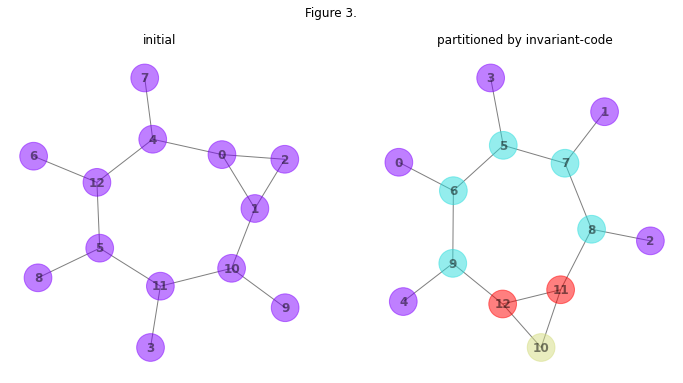

In [4]:
molecule = "fused_bicycle"
m = permute_molecule(graph_from_file(construct_filepath(molecule)), random_seed=.41)
m_partitioned_by_invariants = partition_molecule_by_attribute(m, "invariant_code", include_neighbors=False)
print_molecule(m_partitioned_by_invariants, f"Table 1. {molecule.capitalize()} partitioned by invariant-code.")
draw_molecules([m, m_partitioned_by_invariants], ["initial", "partitioned by invariant-code"], highlight="partition", title="Figure 3.")

### Extended invariant-code
So far, we only considered invariants that pertain to a single node.
However, we can increase the discriminatory power of the local invariants by incorporating information about the direct neighbors of a node `a`, that is, all neighboring nodes that are connected to `a` by a single edge.
For example, nodes 7 and 8 from partition 1 are each connected to three direct neighbors: two carbons, and one hydrogen, as indicated by the leading 6s and 1s of the neighbors' invariant-codes.

| label | invariant-code | partition | neighbors (label, invariant-code, partition) |
|---|---|---|---|
| 7 | 6-1,0 | 1 | (8, 6-1,0, 1), (5, 6-1,0, 1), (1, 1-0, 0)) |
| 8 | 6-1,0 | 1 | (11, 6-2,1,0, 3), (7, 6-1,0, 1), (2, 1-0, 0) |

However, the neighboring carbon atoms with labels 8 and 11 split partition 1, since node 11 is connected to the fundamental cycles 2 and 1, whereas atom 8 is only connected to fundamental cycle 1. That is, we can discriminate the nodes 7 and 8 based on their neighbors' invariant-codes. Similarly, if two nodes belong to the same partition but have a different _number_ of direct neighbors, we can split these nodes' partition based on the number of neighbors.
The extended invariant-code adds two more invariants: the number of direct neighbors as well as the _configuration_ of neighbors. By configuration we mean the tuple of the neighbors' invariant-codes (tuple in the sense of an ordered multiset). 
If we partition the molecule with the extended invariant-code we end up with a total of five partitions, one more compared to the partitioning by local invariants, as can be seen below in `Table 2` and `Figure 4`.

Table 2. Fused_bicycle partitioned by extended invariant-code.
╒═════════╤══════════════════╤═════════════╤═════════════════════════════════════════════════╕
│   label │ invariant-code   │   partition │ neighbors (label, invariant-code, partition)    │
╞═════════╪══════════════════╪═════════════╪═════════════════════════════════════════════════╡
│       0 │ 1-0              │           0 │ (6, 6-1,0, 1)                                   │
├─────────┼──────────────────┼─────────────┼─────────────────────────────────────────────────┤
│       1 │ 1-0              │           0 │ (7, 6-1,0, 1)                                   │
├─────────┼──────────────────┼─────────────┼─────────────────────────────────────────────────┤
│       2 │ 1-0              │           0 │ (8, 6-1,0, 2)                                   │
├─────────┼──────────────────┼─────────────┼─────────────────────────────────────────────────┤
│       3 │ 1-0              │           0 │ (5, 6-1,0, 1)                        

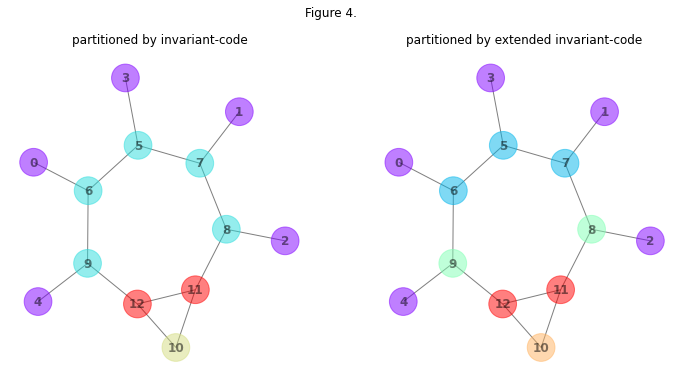

In [5]:
m_partitioned_by_extended_invariants = partition_molecule_by_attribute(m, "invariant_code", include_neighbors=True)
print_molecule(m_partitioned_by_extended_invariants, f"Table 2. {molecule.capitalize()} partitioned by extended invariant-code.")
draw_molecules([m_partitioned_by_invariants, m_partitioned_by_extended_invariants],
               ["partitioned by invariant-code", "partitioned by extended invariant-code"],
               highlight="partition", title="Figure 4.")

When we have a look at nodes 0 through 4 from partition 0 in `Table 2`, we notice that nodes 0, 1, and 3 are connected to neighbors from partition 1, whereas nodes 2 and 4 are connected to neighbors from partition 2.

|   label | invariant-code   |   partition | neighbors (label, invariant-code, partition)     |
|---|---|---|---|
|       0 | 1-0              |           0 | (6, 6-1,0, 1)                                   |
|       1 | 1-0              |           0 | (7, 6-1,0, 1)                                    |
|       2 | 1-0              |           0 | (8, 6-1,0, 2)                                    |
|       3 | 1-0              |           0 | (5, 6-1,0, 1)                                   |
|       4 | 1-0              |           0 | (9, 6-1,0, 2)                                   |


This means that we can further discriminate the nodes in partition 0 based on the partitions of their neighbors.
In other words, we can refine the partitions recursively ("partitioning by partition").
Below we show what happens if we repeat the recursive partitioning until the number of partitions doesn't change anymore:
throughout two rounds of refinement, we go from five to seven to eventually eight partitions. Recursive partitioning is conceptually related to _color-refinement_ in the sense of the _Weisfeiler-Leman_ algorithm ([Kiefer, 2020](https://sci-hub.ru/https://doi.org/10.1145/3436980.3436982); [Bieber, 2019](https://www.davidbieber.com/post/2019-05-10-weisfeiler-lehman-isomorphism-test/)), which is known in chemistry as the _Morgan_ algorithm ([Morgan, 1965](https://sci-hub.ru/https://doi.org/10.1021/c160017a018)).


refined partitions
╒═════════╤══════════════════╤═════════════╤═════════════════════════════════════════════════╕
│   label │ invariant-code   │   partition │ neighbors (label, invariant-code, partition)    │
╞═════════╪══════════════════╪═════════════╪═════════════════════════════════════════════════╡
│       0 │ 1-0              │           0 │ (6, 6-1,0, 1)                                   │
├─────────┼──────────────────┼─────────────┼─────────────────────────────────────────────────┤
│       1 │ 1-0              │           0 │ (7, 6-1,0, 1)                                   │
├─────────┼──────────────────┼─────────────┼─────────────────────────────────────────────────┤
│       2 │ 1-0              │           0 │ (5, 6-1,0, 1)                                   │
├─────────┼──────────────────┼─────────────┼─────────────────────────────────────────────────┤
│       3 │ 1-0              │           0 │ (8, 6-1,0, 2)                                   │
├─────────┼──────────────────┼─

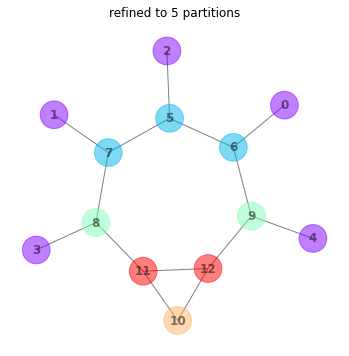

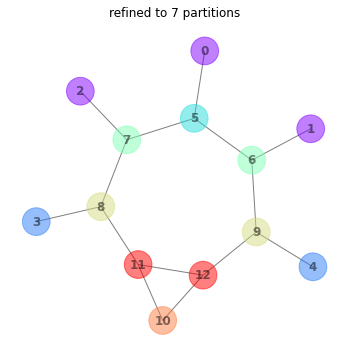

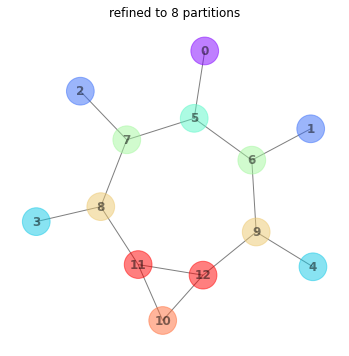

In [6]:
m_partitioned = partition_molecule_recursively(m_partitioned_by_extended_invariants, show_steps=True)

After the recursive refinement of the partitions, no partition contains more than two nodes. This brings us closer to the ultimate goal of the canonicalization, that is, we are closer to shattering the molecule such that each node resides in a unique partition. We hope to demonstrate in the following that for many molecules, in order to canonicalize them, it's not necessary to permute the partitions (i.e., automorphism groups). Instead, we show that a molecule can be canonicalized once we're able to traverse the molecular graph in a deterministic manner.

## Molecule traversal
We can traverse a graphs nodes in a deterministic manner if we can establishing branching priorities. More concretely, we need a principle by which we can decide which node to branch to in situations where the traversal can branch to multiple neighbors from node `a`. We can establish branching priorities based on the partitions as follows.
1. If available, branch to neighbor from smaller partition than `a`'s partition.
2. If available, branch to neighbor from greater partition than `a`'s partition.
3. If available, branch to neighbor from same partition as `a`.
Note that the order of the priorities isn't relevant as long as it's applied consistently (throughout the canonicalization of graphs that are meant to be compared based on their canonicalization).

In order to canonicalize the graph during the traversal, we swap the labels such that the current nodes `a` from partition `P` gets assigned the smallest-available label `l` that remains in partition `P`. Once assigned, `l` is removed from `P`.

Below we relabel the nodes while traversing a graph in [breadth-first-search-order](https://en.wikipedia.org/wiki/Breadth-first_search), while the branching priorities are determined by the partitions as discussed above.

Current atom index: 0.	Re-labeling to 0.
Current atom index: 5.	Re-labeling to 5.
Current atom index: 6.	Re-labeling to 6.
Current atom index: 7.	Re-labeling to 7.
Current atom index: 9.	Re-labeling to 8.
Current atom index: 1.	Re-labeling to 1.
Current atom index: 8.	Re-labeling to 9.
Current atom index: 2.	Re-labeling to 2.
Current atom index: 12.	Re-labeling to 11.
Current atom index: 4.	Re-labeling to 3.
Current atom index: 11.	Re-labeling to 12.
Current atom index: 3.	Re-labeling to 4.
Current atom index: 10.	Re-labeling to 10.


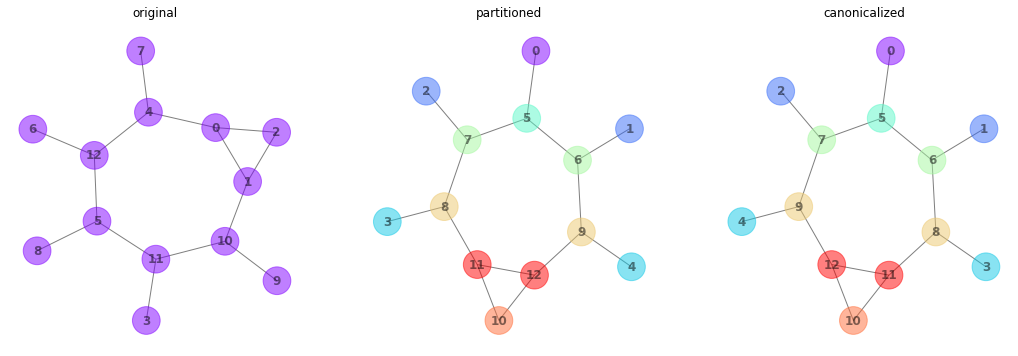

In [7]:
canonical_idcs = assign_canonical_labels(m_partitioned, 0, show_traversal_order=True)
m_canonicalized = nx.relabel_nodes(m_partitioned, canonical_idcs, copy=True)
draw_molecules([m, m_partitioned, m_canonicalized], ["original", "partitioned", "canonicalized"], highlight="partition")

There are a few limitations to this approach. Firstly, branching deterministically based on partitions only works if the following is true. If we can branch to multiple atoms from the _same_ partition, these atoms must belong to the same automorphism group. Since we cannot guarantee that atoms from one partition are automorphic (see "Molecule partitioning based on node-invariants" above), we need to exhaustively permute those partitions (TODO: elaborate).


Secondly, the canonical labeling depends on where the traversal starts (root node). Below we once start traversing terephthalic acid from node 0 (partition 0), and once we start from node 4 (partition 1). Note the resulting discrepancy in canonical labeling. TODO: What are the implications of this? 

Starting traversal from node 0
Current atom index: 0.	Re-labeling to 0.
Current atom index: 8.	Re-labeling to 8.
Current atom index: 12.	Re-labeling to 12.
Current atom index: 11.	Re-labeling to 9.
Current atom index: 6.	Re-labeling to 6.
Current atom index: 9.	Re-labeling to 10.
Current atom index: 13.	Re-labeling to 13.
Current atom index: 1.	Re-labeling to 1.
Current atom index: 14.	Re-labeling to 14.
Current atom index: 16.	Re-labeling to 16.
Current atom index: 3.	Re-labeling to 2.
Current atom index: 10.	Re-labeling to 11.
Current atom index: 7.	Re-labeling to 7.
Current atom index: 4.	Re-labeling to 4.
Current atom index: 2.	Re-labeling to 3.
Current atom index: 15.	Re-labeling to 15.
Current atom index: 17.	Re-labeling to 17.
Current atom index: 5.	Re-labeling to 5.

Starting traversal from node 0
Current atom index: 4.	Re-labeling to 4.
Current atom index: 16.	Re-labeling to 16.
Current atom index: 6.	Re-labeling to 6.
Current atom index: 12.	Re-labeling to 12.
Current atom in

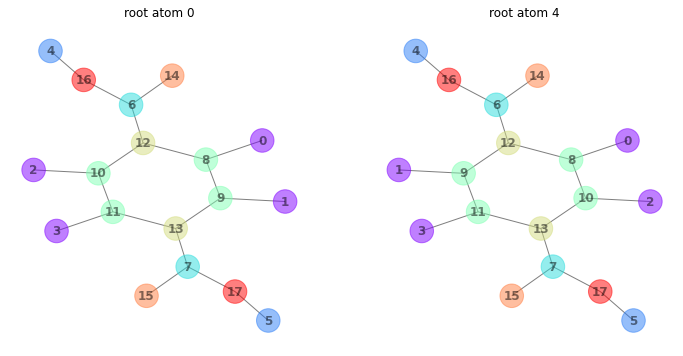

In [8]:
m = graph_from_file(construct_filepath("terephthalic_acid"))
m_partitioned = partition_molecule_by_attribute(m, "invariant_code", include_neighbors=True)
m_partitioned = partition_molecule_recursively(m_partitioned)
print("Starting traversal from node 0")
canonical_labels_0 = assign_canonical_labels(m_partitioned, 0, show_traversal_order=True)
print("\nStarting traversal from node 0")
canonical_labels_4 = assign_canonical_labels(m_partitioned, 4, show_traversal_order=True) 
draw_molecules([nx.relabel_nodes(m_partitioned, canonical_labels_0, copy=True),
                nx.relabel_nodes(m_partitioned, canonical_labels_4, copy=True)],
               ["root atom 0", "root atom 4"], highlight="partition")

# Serialization
The serialization should result in a string representation of the molecule. The string representation should allow for the automatized reconstruction of the molecule's topology (i.e., the molecular graph), and ideally, the representation should be intuitive enough for a human to be able to reconstruct the molecular graph.

Our string representation consists of the sum formula, followed by a sequence of tuples. Each tuple represents the labels of two connected atoms (i.e., (label atom_A, label atom_B)). For example, the string representation of ethanol is `C2H6O/0-6/1-6/2-6/3-7/4-7/5-8/6-7/7-8`. In order to be able to reconstruct the molecule based on this representation, we organize the tuples such that increasing atom labels pertain to atoms with increasing atomic number. This means that we can infer the atomic number associated with an atom label from the sum formula. For example, the sum formula of ethanol indicates that the molecule consists of six Hs, two Cs and one O. Since increasing labels pertain to atoms with increasing atomic numbers, we can infer that the labels 0 through 6 pertain to Hs, labels 7 and 8 pertain to Cs, and finally, label 8 pertains to an O.

In [9]:
testfiles = list(Path("tests/molfiles").glob("*/*.mol"))
for f in testfiles:
    m = graph_from_file(f)
    print(f"{f.stem}:\n{serialize_molecule(canonicalize_molecule(m, 0))}\n")

10tertButyl10isopropyltridecanoic acid:
C20H40O2/0-40/1-40/2-40/3-41/4-41/5-41/6-42/7-42/8-42/9-43/10-43/11-43/12-44/13-44/14-44/15-45/16-45/17-45/18-46/19-46/20-47/21-47/22-48/23-48/24-49/25-49/26-50/27-50/28-51/29-51/30-52/31-52/32-53/33-53/34-54/35-54/36-55/37-55/38-56/39-61/40-46/41-56/42-56/43-57/44-57/45-57/46-53/47-48/47-49/48-50/49-51/50-52/51-54/52-55/53-58/54-58/55-59/56-58/57-58/59-60/59-61

14Ethyl14methylheptadecanoic acid:
C20H40O2/0-40/1-40/2-40/3-41/4-41/5-41/6-42/7-42/8-42/9-43/10-43/11-44/12-44/13-45/14-45/15-46/16-46/17-47/18-47/19-48/20-48/21-49/22-49/23-50/24-50/25-51/26-51/27-52/28-52/29-53/30-53/31-54/32-54/33-55/34-55/35-56/36-56/37-57/38-57/39-61/40-43/41-54/42-58/43-55/44-45/44-46/45-47/46-48/47-49/48-50/49-51/50-52/51-53/52-56/53-57/54-58/55-58/56-58/57-59/59-60/59-61

18Methylnonadecanoic acid:
C20H40O2/0-40/1-40/2-40/3-41/4-41/5-41/6-42/7-42/8-43/9-43/10-44/11-44/12-45/13-45/14-46/15-46/16-47/17-47/18-48/19-48/20-49/21-49/22-50/23-50/24-51/25-51/26-52/27-52